# Part 3 – Gold layer
- Read cleaned and standardized silver data
- Build business-ready tables and feature sets
- Apply domain rules (price per m², price index adjustments, derived attributes)
- Aggregate to useful granularities (daily, monthly, regional summaries)
- Produce final consumption tables for BI dashboards, ML models, and reports
- Store as curated datasets in a stable schema (parquet or Delta)
- Add data quality checks for completeness and consistency at the business level

In [2]:
print("Ok")
# Import Required Libraries
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import random
import json
import findspark
import csv
from io import StringIO
import re
import time
import math

import tensorflow as tf
from tensorflow import keras
import joblib

findspark.init()

# PySpark availability check
try:
    # Test PySpark availability
    from pyspark.sql import SparkSession

    # PySpark Core
    from pyspark.sql.functions import *
    from pyspark.sql.functions import (
        col,
        when,
        year,
        month,
        lit,
        isnan,
        isnull,
        sum as spark_sum,
    )
    from pyspark.sql.types import *
    from pyspark.sql import functions as F

    # PySpark ML
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import (
        StringIndexer,
        VectorAssembler,
        StandardScaler,
        OneHotEncoder,
    )
    from pyspark.ml.regression import GBTRegressor
    from pyspark.ml.evaluation import RegressionEvaluator

    from sklearn.inspection import permutation_importance
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.preprocessing import LabelEncoder
    from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error

    import lightgbm as lgb
    import xgboost as xgb
    from catboost import CatBoostRegressor

    pyspark_available = True
    print("PySpark is available!")
except ImportError:
    print("PySpark not found. Please install with: pip install pyspark")
    pyspark_available = False

if not pyspark_available:
    raise ImportError("Cannot proceed without PySpark. Please install PySpark first.")

# Create SparkSession with custom configuration
spark = (
    SparkSession.builder.appName("DAT535-Project")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "1g")
    .getOrCreate()
)

# Set log level
spark.sparkContext.setLogLevel("WARN")

# Check your current session
print(f"Current App Name: {spark.sparkContext.appName}")
print(f"Application ID: {spark.sparkContext.applicationId}")
print(f"Web UI: {spark.sparkContext.uiWebUrl}")
print("Ok")

Ok


2025-11-25 13:53:15.977123: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-25 13:53:17.434481: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-25 13:53:21.080647: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


PySpark is available!


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/25 13:53:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Current App Name: DAT535-Project
Application ID: local-1764078807714
Web UI: http://dat535-ass1:4040
Ok


### Loading data

In [2]:
# Load the cleaned silver data
df_silver = spark.read.parquet("data/ukprop_silver.parquet")
df_silver = df_silver.sample(withReplacement=False, fraction=1.0, seed=42.0)  # 0.1% sample for testing

def check_df(df):
    # Memory cehck
    print(f"DataFrame count: {df.count()}")
    print(f"DataFrame size: {df.count() * len(df.columns)} records")
    
    # Partitions check
    print(f"Number of partitions: {df.rdd.getNumPartitions()}")
    print(f"Shape: ({df.count()}, {len(df.columns)})")
    print(f"Shape: {df.count()} rows, {len(df.columns)} columns")
    display(df.limit(3).toPandas())

check_df(df_silver)


DataFrame count: 5499993
DataFrame size: 120999846 records
Number of partitions: 5
Shape: (5499993, 22)
Shape: 5499993 rows, 22 columns


,transactionid,price,dateoftransfer,postcode,propertytype,number_heated_rooms,floor_height,current_energy_rating,oldnew,duration,...,district,county15,categorytype,recordstatus,tfarea,numberrooms,_source,_ingestion_timestamp,_status,year
0,5f2b8b60-b9d0-4f00-8561-8bbf0c991be1,187250.0,2014-07-11,kt227ln,flat,2,NaN,c,old,leasehold,...,None,ln,standard price paid entry.,addition,46,2,data/ukprop_bronze.parquet,1.7636300004847977E9,cleaned,2014
1,1e5ccec3-9449-4c7f-86f3-d11e3149bfcc,240500.0,2014-12-05,sm53qj,flat,3,2.32,d,old,leasehold,...,None,on,standard price paid entry.,addition,16,3,data/ukprop_bronze.parquet,1.7636305697588892E9,cleaned,2014
2,df7ff768-c49a-46d2-ac47-ef0f96799040,138000.0,2014-06-19,rh41hh,flat,3,2.38,b,old,leasehold,...,None,on,standard price paid entry.,addition,57,3,data/ukprop_bronze.parquet,1.7636300004871871E9,cleaned,2014


### Outlier removal

In [3]:
df_silver.describe(["price", "floor_height", "tfarea", "numberrooms"]).show()

25/11/25 13:34:24 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-------------------+------------------+------------------+
|summary|             price|       floor_height|            tfarea|       numberrooms|
+-------+------------------+-------------------+------------------+------------------+
|  count|           5499993|            2065349|           5499993|           5499993|
|   mean|257622.66823248685|  2.452703965126924|184.77581280557993| 4.654907197154615|
| stddev|267377.74036438455|0.37769516454167695|10041.284844646554|1.6145426570811636|
|    min|            6500.0|                0.0|                 2|                 1|
|    max|           3.772E7|              256.0|           9333566|                20|
+-------+------------------+-------------------+------------------+------------------+



In [4]:
df_silver = df_silver.filter((col("floor_height") > 0) & (col("floor_height") < 10))

In [5]:
numeric_cols = ["price", "floor_height", "tfarea", "numberrooms"]
quantiles = df_silver.approxQuantile(numeric_cols, [0.025, 0.975], 0.01) # 0.01 error cus I like speed and not inf waiting time

conditions = []
for i, col_name in enumerate(numeric_cols):
    low, high = quantiles[i]
    conditions.append((col(col_name) >= low) & (col(col_name) <= high))

# combine conditions
final_condition = conditions[0]
for cond in conditions[1:]:
    final_condition = final_condition & cond

df_clean = df_silver.filter(final_condition)

print(f"Original rows: {df_silver.count()}, After outlier removal: {df_clean.count()}")
df_silver = df_clean
df_clean.cache()

Original rows: 2065070, After outlier removal: 1821372


DataFrame[transactionid: string, price: double, dateoftransfer: string, postcode: string, propertytype: string, number_heated_rooms: string, floor_height: double, current_energy_rating: string, oldnew: string, duration: string, locality: string, city: string, district: string, county15: string, categorytype: string, recordstatus: string, tfarea: int, numberrooms: int, _source: string, _ingestion_timestamp: string, _status: string, year: int]


### Feature selection

In [6]:
print("Distinct cities", df_silver.select("city").distinct().count()) # 10< unecessarily many
print("Distinct postcode_out", df_silver.select("postcode").distinct().count()) # 10< unecessarily many

Distinct cities 1153


[Stage 31:=======================>                                  (2 + 3) / 5]

Distinct postcode_out 664478


Top top_n_cities cities by frequency:
1. london 106582
2. bristol 30636
3. manchester 28370
4. nottingham 26679
5. birmingham 25913
6. leeds 21086
7. sheffield 17938
8. southampton 16404
9. liverpool 15941
10. leicester 15860
11. norwich 14821
12. cardiff 13371
13. reading 11962
14. northampton 11693
15. york 11373


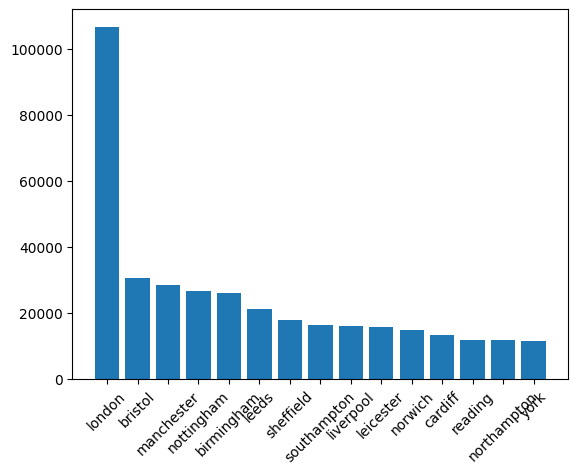

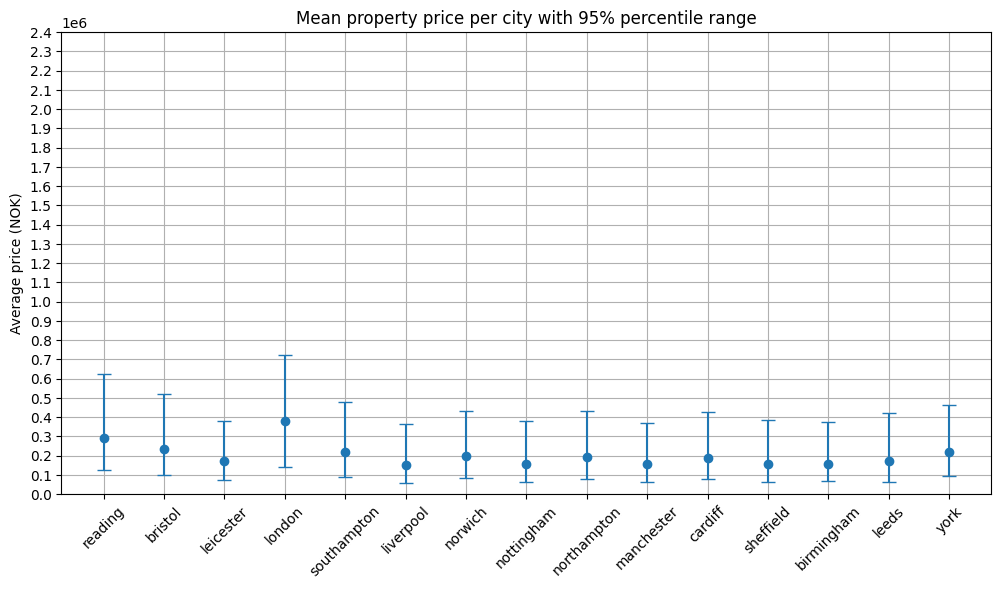

In [7]:
# Only use top 10 cities
top_n_cities = 15
top_cities = df_silver.groupBy("city").count().orderBy("count", ascending=False).limit(top_n_cities)
top_cities_list = [row["city"] for row in top_cities.collect()]
top_cities_list_count = [row["count"] for row in top_cities.collect()]

print("Top top_n_cities cities by frequency:")
for i, city in enumerate(top_cities_list, 1):
    print(f"{i}. {city} {top_cities_list_count[i-1]}")

plt.bar(top_cities_list, top_cities_list_count)
plt.xticks(rotation=45)
plt.show()

from pyspark.sql.functions import expr

quantiles = df_silver.filter(col("city").isin(top_cities_list)) \
    .groupBy("city") \
    .agg(
        expr('percentile_approx(price, 0.025)').alias("p2_5"),
        expr('percentile_approx(price, 0.975)').alias("p97_5"),
        avg("price").alias("mean_price")
    ).collect()

cities = [row['city'] for row in quantiles]
means = [row['mean_price'] for row in quantiles]
ci_lower = [row['mean_price'] - row['p2_5'] for row in quantiles]
ci_upper = [row['p97_5'] - row['mean_price'] for row in quantiles]

plt.figure(figsize=(12,6))
plt.errorbar(cities, means, yerr=[ci_lower, ci_upper], fmt='o', capsize=5)
plt.xticks(rotation=45)
plt.ylabel("Average price (NOK)")
plt.yticks(np.arange(0, 2_500_000, 100_000))
plt.grid()
plt.title("Mean property price per city with 95% percentile range")
plt.show()


We see that London contains a lot of different data, but a lot also has been filtered out due to the outlier removal, so the price data looks fine.

In [8]:
max_year = df_silver.agg(year(max("dateoftransfer"))).collect()[0][0]
min_year = df_silver.agg(year(min("dateoftransfer"))).collect()[0][0]
print("max year :",max_year)
print("min year :",min_year)
print("Distinct years", df_silver.select("year").distinct().count(), "?= Max-Min years", max_year-min_year+1)

max year : 2019
min year : 2011
Distinct years 9 ?= Max-Min years 9


In [9]:
# checking for null values
for c in df_silver.columns:
    #print(c, df_gold.filter(F.col(c).isNull()).count())
    print(c, df_silver.filter(col(c).isNull()).count())

transactionid 0
price 0
dateoftransfer 0
postcode 0
propertytype 0
number_heated_rooms 0
floor_height 0
current_energy_rating 0
oldnew 0
duration 0
locality 1457310
city 0
district 1821372
county15 0
categorytype 909725
recordstatus 909725
tfarea 0
numberrooms 0
_source 0
_ingestion_timestamp 0
_status 0
year 0


#### No need to drop null value rows since they are not among the useful features that we will use anyway.
Usefull features: [year, propertytype, current_energy_rating, oldnew, city, categorytype, tfarea, numberrooms]
### Usefull features can be determined by doing a feature permutation importance test. 
(from here on GPT was of great use given our lack of education and experience with model building)

After cleaning: 100000 samples


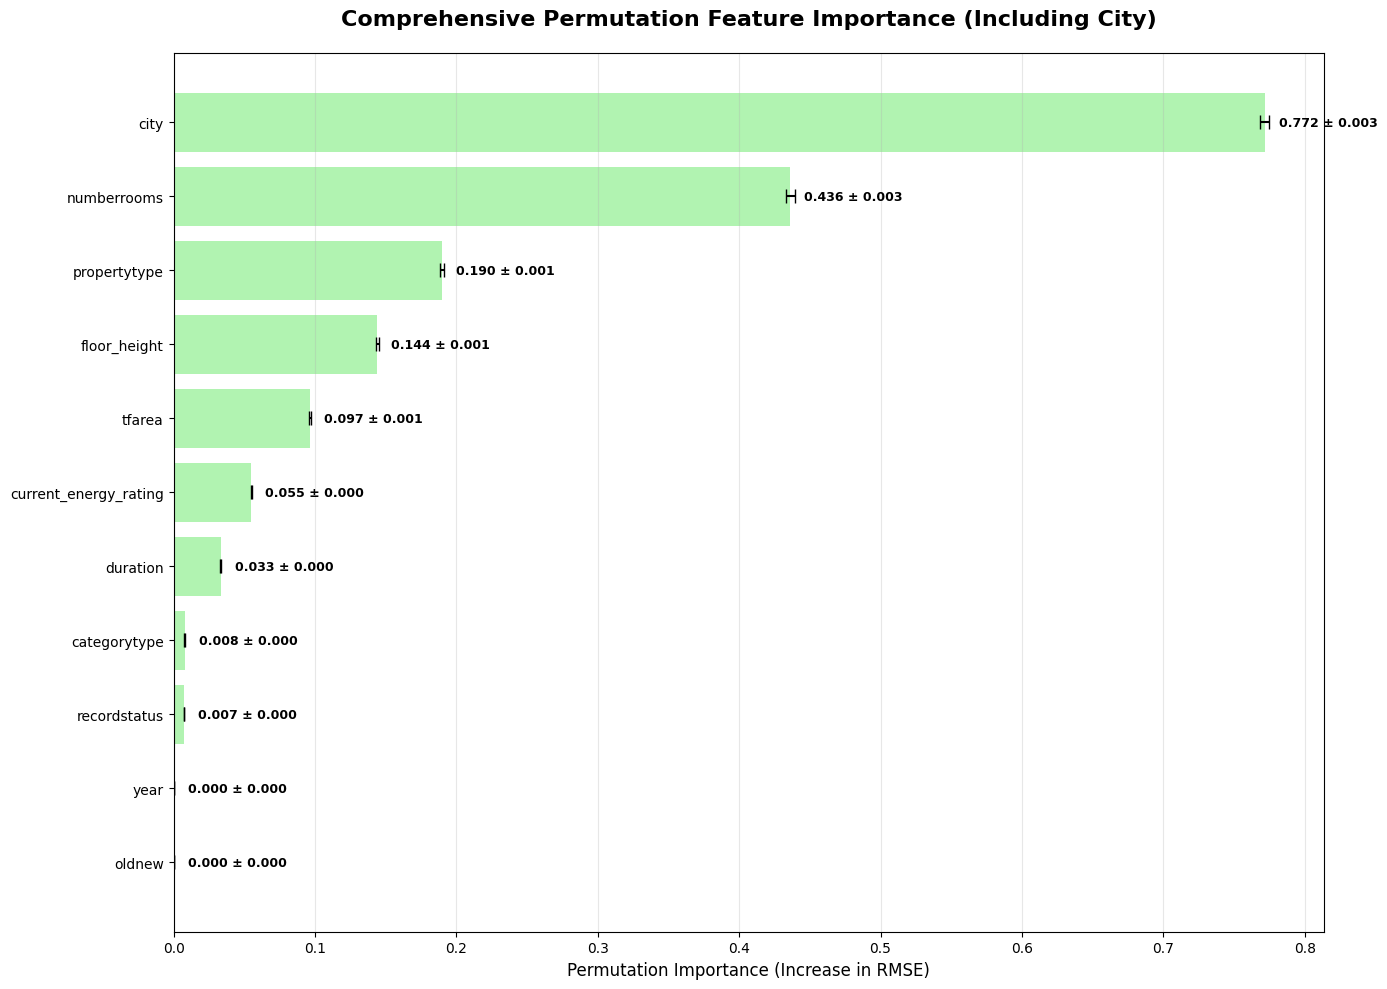

PERMUTATION IMPORTANCE RESULTS (All Features)
Feature Importance (mean ± std):


,feature,mean_importance,std_importance,importance_level
0,city,0.771566,0.003394,HIGH
1,numberrooms,0.436138,0.003093,MEDIUM
2,propertytype,0.189678,0.001243,MEDIUM
3,floor_height,0.144081,0.000984,MEDIUM
4,tfarea,0.096613,0.000919,LOW
5,current_energy_rating,0.054855,0.000464,LOW
6,duration,0.033332,0.000382,LOW
7,categorytype,0.007760,0.000177,
8,recordstatus,0.007491,0.000137,
9,year,0.000000,0.000000,



MODEL PERFORMANCE METRICS
MAE: £52,126
R^2: 0.6717
Baseline RMSE (naive mean prediction): £127,054

FEATURE IMPORTANCE BY CATEGORY
Structural          : 0.6768
Location            : 0.7716
Property Type       : 0.2230
Energy              : 0.0549
Administrative      : 0.0153


In [10]:
df_sample = df_silver.limit(100000).toPandas()

feature_columns = [
    'propertytype', 'current_energy_rating', 'oldnew', 'duration', 
    'categorytype', 'recordstatus', 'tfarea', 'numberrooms', 
    'floor_height', 'year', 'city'
]

X = df_sample[feature_columns].copy()
y = df_sample['price'].values

# Data cleaning
mask = (
    (y > 0) & 
    (X['tfarea'] > 0) & 
    (X['numberrooms'] > 0) &
    (X['city'].notna())  # Ensure city is not null
)
X = X[mask]
y = y[mask]

print(f"After cleaning: {len(X)} samples")

# Encode categorical variables - INCLUDING CITY
categorical_columns = [
    'propertytype', 'current_energy_rating', 'oldnew', 
    'duration', 'categorytype', 'recordstatus', 'city'
]

label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    # Handle missing values and convert to string
    X[column] = X[column].fillna('unknown').astype(str)
    
    # For city, group infrequent cities as 'other'
    if column == 'city':
        city_counts = X[column].value_counts()
        infrequent_cities = city_counts[city_counts < 100].index  # Adjust threshold as needed
        X[column] = X[column].apply(lambda x: 'other' if x in infrequent_cities else x)
    
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

# Handle missing values in numeric columns
numeric_columns = ['tfarea', 'numberrooms', 'floor_height', 'year']
for column in numeric_columns:
    X[column] = X[column].fillna(X[column].median())

# Train model with more trees for better stability
rf_sklearn = RandomForestRegressor(
    n_estimators=100,
    max_depth=15, 
    random_state=42, 
    n_jobs=-1
)
rf_sklearn.fit(X, y)

# Calculate permutation importance with more repeats
perm_importance = permutation_importance(
    rf_sklearn, X, y, 
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Plot results
feature_names = X.columns
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

plt.figure(figsize=(14, 10))
bars = plt.barh(range(len(sorted_idx)), 
                perm_importance.importances_mean[sorted_idx],
                xerr=perm_importance.importances_std[sorted_idx],
                color='lightgreen',
                alpha=0.7,
                capsize=5)

plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel("Permutation Importance (Increase in RMSE)", fontsize=12)
plt.title("Comprehensive Permutation Feature Importance (Including City)", 
          fontsize=16, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add importance values on bars
for i, (bar, imp_mean, imp_std) in enumerate(zip(bars, 
                                                perm_importance.importances_mean[sorted_idx],
                                                perm_importance.importances_std[sorted_idx])):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{imp_mean:.3f} ± {imp_std:.3f}', 
             ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("PERMUTATION IMPORTANCE RESULTS (All Features)")
print("Feature Importance (mean ± std):")

def importance_level(mean_imp):
    if mean_imp > 0.5:
        return "HIGH"
    elif mean_imp > 0.1:
        return "MEDIUM"
    elif mean_imp > 0.01:
        return "LOW"
    else:
        return ""

importance_df = pd.DataFrame({
    "feature": feature_names[sorted_idx],
    "mean_importance": perm_importance.importances_mean[sorted_idx],
    "std_importance": perm_importance.importances_std[sorted_idx]
})
importance_df["importance_level"] = importance_df["mean_importance"].apply(importance_level)

display(importance_df)

# Additional: Get baseline model performance
y_pred = rf_sklearn.predict(X)

print("\nMODEL PERFORMANCE METRICS")
print(f"MAE: £{mean_absolute_error(y, y_pred):,.0f}")
print(f"R^2: {r2_score(y, y_pred):.4f}")
print(f"Baseline RMSE (naive mean prediction): £{np.sqrt(np.mean((y - y.mean())**2)):,.0f}")

print("\nFEATURE IMPORTANCE BY CATEGORY")
categories = {
    'Structural': ['tfarea', 'numberrooms', 'floor_height'],
    'Location': ['city'],
    'Property Type': ['propertytype', 'oldnew', 'duration'],
    'Energy': ['current_energy_rating'],
    'Administrative': ['categorytype', 'recordstatus', 'year']
}

for category, features in categories.items():
    total_importance = __builtins__.sum(perm_importance.importances_mean[X.columns.get_loc(f)] 
                          for f in features if f in X.columns)
    print(f"{category:<20}: {total_importance:.4f}")

Conclusion: we see that some features are really important and others not, given for example how city has like 10k+ unique values, we will be selective and only go for the most common cities. Also intuitively room number and total floor area is also important.

### Feature engineering

In [11]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, lit, year, month, when, create_map
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

energy_map = {"a": 7, "b": 6, "c": 5, "d": 4, "e": 3, "f": 2, "g": 1}
energy_map_list = []
for k, v in energy_map.items():
    energy_map_list.append(lit(k))
    energy_map_list.append(lit(v))

mapping_expr = create_map(*energy_map_list)

# Date normalisation
stats = df_silver.select(
    F.min(year(col("dateoftransfer"))).alias("miny"),
    F.max(year(col("dateoftransfer"))).alias("maxy"),
).first()
min_year, max_year = stats.miny, stats.maxy

# Feature engineering
df_gold = (
    df_silver.withColumn(
        "year_encoded",
        (year(col("dateoftransfer")) - lit(min_year)) / lit(max_year - min_year),
    )
    .withColumn("month_encoded", month(col("dateoftransfer")) / lit(12.0))
    .withColumn(
        "city_encoded",
        when(col("city").isin(top_cities_list), col("city")).otherwise(
            lit("city_other")
        ),
    )
    .withColumn(
        "old_new_numeric", when(col("oldnew") == "new", lit(1)).otherwise(lit(0))
    )
    .withColumn(
        "duration_numeric",
        when(col("duration") == "leasehold", lit(1)).otherwise(lit(0)),
    )
    .withColumn("energy_numeric", mapping_expr[col("current_energy_rating")])
    .withColumn("rooms_numeric", col("numberrooms").cast("double"))
    .withColumn("area_numeric", col("tfarea").cast("double"))
    .select(
        "price",
        "propertytype",
        "city_encoded",
        "old_new_numeric",
        "duration_numeric",
        "year_encoded",
        "month_encoded",
        "energy_numeric",
        "rooms_numeric",
        "area_numeric",
    )
)


# Save gold layer
df_gold.write.mode("overwrite").parquet("data/gold.parquet")

# Prepare ML pipeline components
property_indexer = StringIndexer(inputCol="propertytype", outputCol="property_index")
city_indexer = StringIndexer(inputCol="city_encoded", outputCol="city_index")

encoder = OneHotEncoder(
    inputCols=["property_index", "city_index"],
    outputCols=["property_encoded", "city_encoded_vec"],
)

numeric_cols = [
    "old_new_numeric",
    "duration_numeric",
    "year_encoded",
    "month_encoded",
    "energy_numeric",
    "rooms_numeric",
    "area_numeric",
]


assembler = VectorAssembler(
    inputCols=["property_encoded", "city_encoded_vec"] + numeric_cols,
    outputCol="features",
    handleInvalid="skip",
)


pipeline = Pipeline(stages=[property_indexer, city_indexer, encoder, assembler])
pipeline_model = pipeline.fit(df_gold)
df_processed = pipeline_model.transform(df_gold)


# Save processed feature dataframe
df_processed.select("price", "features").write.mode("overwrite").parquet("data/gold_features.parquet")

## End of gold layer


## Algo implementation below 
- (could have been added in a seperate notebook, but we choose not to)

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

# Load processed features
df_feat = spark.read.parquet("data/gold_features.parquet")
sample_pd = df_feat.limit(300000).toPandas()

# Extract numeric + one-hot parts
X_arr = np.array([v.toArray() for v in sample_pd["features"]])
y = sample_pd["price"].values

# Last 7 numeric
total_dim = X_arr.shape[1]
num_cols_count = 7
onehot_dim = total_dim - num_cols_count

X_onehot = X_arr[:, :onehot_dim]
X_num = X_arr[:, onehot_dim:]

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

X = np.hstack([X_onehot, X_num_scaled])

y_log = np.log1p(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

lgb_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=31)
lgb_model.fit(X_train, y_train)
y_pred_lgb = np.expm1(lgb_model.predict(X_test))
rmse_lgb = mean_squared_error(np.expm1(y_test), y_pred_lgb)
print("LightGBM RMSE", rmse_lgb)

xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=7)
xgb_model.fit(X_train, y_train)
y_pred_xgb = np.expm1(xgb_model.predict(X_test))
rmse_xgb = mean_squared_error(np.expm1(y_test), y_pred_xgb)
print("XGBoost RMSE", rmse_xgb)

cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, verbose=False)
cat_model.fit(X_train, y_train)
y_pred_cat = np.expm1(cat_model.predict(X_test))
rmse_cat = mean_squared_error(np.expm1(y_test), y_pred_cat)
print("CatBoost RMSE", rmse_cat)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 254
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 24
[LightGBM] [Info] Start training from score 12.062823


/home/ubuntu/spark-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM RMSE 8420307845.947831
XGBoost RMSE 8448985413.555026
CatBoost RMSE 8407064056.543931


In [6]:
# Random sampling
np.random.seed(42)
idx_sample = np.random.choice(len(X_test), 10000, replace=False)
X_sample = X_test[idx_sample]
y_sample = np.expm1(y_test[idx_sample])  # convert back to original scale

pred_lgb = np.expm1(lgb_model.predict(X_sample))
pred_xgb = np.expm1(xgb_model.predict(X_sample))
pred_cat = np.expm1(cat_model.predict(X_sample))

def pct_error(y_true, y_pred):
    return 100 * np.abs(y_pred - y_true) / y_true

err_lgb = pct_error(y_sample, pred_lgb)
err_xgb = pct_error(y_sample, pred_xgb)
err_cat = pct_error(y_sample, pred_cat)

avg_lgb = np.mean(err_lgb)
avg_xgb = np.mean(err_xgb)
avg_cat = np.mean(err_cat)

# Summary DataFrame
results_df = pd.DataFrame({
    "model": ["LightGBM", "XGBoost", "CatBoost"],
    "avg_pct_error": [avg_lgb, avg_xgb, avg_cat]
})

display(results_df)

# Show 15 sample predictions
for i in range(15):
    print(
        f"LGB {pred_lgb[i]:.0f} ({err_lgb[i]:.1f}%), "
        f"XGB {pred_xgb[i]:.0f} ({err_xgb[i]:.1f}%), "
        f"CAT {pred_cat[i]:.0f} ({err_cat[i]:.1f}%), "
        f"actual={y_sample[i]:.0f}"
    )


/home/ubuntu/spark-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,model,avg_pct_error
0,LightGBM,33.910832
1,XGBoost,33.984483
2,CatBoost,33.869444


LGB 199715 (16.8%), XGB 197937 (17.5%), CAT 200813 (16.3%), actual=240000
LGB 241063 (2.8%), XGB 240179 (3.2%), CAT 240092 (3.2%), actual=248000
LGB 178128 (6.7%), XGB 177666 (7.0%), CAT 179995 (5.8%), actual=191000
LGB 366876 (48.0%), XGB 368262 (47.8%), CAT 363949 (48.4%), actual=705000
LGB 129438 (21.0%), XGB 121764 (13.8%), CAT 131756 (23.1%), actual=107000
LGB 140103 (15.9%), XGB 139066 (16.5%), CAT 139894 (16.0%), actual=166500
LGB 283156 (26.1%), XGB 283722 (25.9%), CAT 285489 (25.5%), actual=383000
LGB 162552 (1.5%), XGB 162817 (1.3%), CAT 163312 (1.0%), actual=165000
LGB 169130 (5.0%), XGB 167695 (5.8%), CAT 168873 (5.1%), actual=178000
LGB 150414 (124.5%), XGB 149555 (123.2%), CAT 149857 (123.7%), actual=67000
LGB 203022 (63.1%), XGB 203921 (62.9%), CAT 203687 (63.0%), actual=550000
LGB 96741 (54.8%), XGB 100219 (60.4%), CAT 98973 (58.4%), actual=62500
LGB 145259 (0.2%), XGB 145970 (0.7%), CAT 143596 (0.9%), actual=144950
LGB 441581 (1.9%), XGB 398940 (11.3%), CAT 486963 (8.2

### END OF ALGO IMPLEMENTATION SHOWCASE